In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker
from matplotlib import cm 
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from fractions import Fraction
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
def fun(x: list) -> float:
    return (x[0]**2 + 10*(x[1]**2)) / 2
    
def grad(x: list) -> float:
    return np.array([float(x[0]), float(10*x[1])]) 

In [3]:
def min_gd_i_fixed(fun, x0, grad, t): 
    dx = -grad(x0)
    mylist = []
    while (np.max(np.abs(dx)) > 1.e-7):
        mylist.append(float((x0[0]**2 + 10*(x0[1]**2)) / 2))
        x0 = x0 + t*dx
        dx = -grad(x0)   
    return mylist

In [4]:
def min_gd_i_fixed_len_lastval(fun, x0, grad, t): 
    dx = -grad(x0)
    mylist = []
    while (np.max(np.abs(dx)) > 1.e-7):
        mylist.append(float((x0[0]**2 + 10*(x0[1]**2)) / 2))
        x0 = x0 + t*dx
        dx = -grad(x0)   
    return len(mylist), mylist[-1]

In [5]:
def min_gd_ii_fixed(fun, x0, grad, t):
    dx = -grad(x0)
    while (np.max(np.abs(dx)) > 1e-07):
        x0 = x0 + t*dx
        dx = -grad(x0)   
    return list(x0)

In [6]:
def min_gd_iii_fixed(fun, x0, grad, t):
    dx = -grad(x0)
    minsequencelist = []
    while (np.max(np.abs(dx)) > 1e-07):
        minsequencelist.append(list(x0))
        x0 = x0 + t*dx
        dx = -grad(x0)  
    minsequencelist.append(list(x0))
    return(minsequencelist)

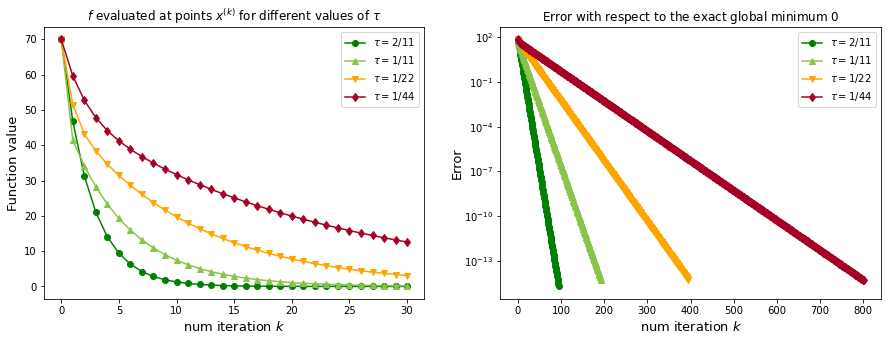

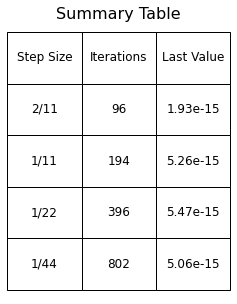

In [7]:
t_vals = [Fraction(2, 11), Fraction(2, 22), Fraction(2, 44), Fraction(2, 88)] 
colors = ['green', '#8bc34a', 'orange', '#a50026']
markers = ['o', '^', 'v', 'd']
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, t in enumerate(t_vals):
    var_fixed = min_gd_i_fixed(fun, [10, 2], grad, t)
    axs[0].plot(var_fixed[:31], color=colors[i], marker=markers[i], mfc=colors[i], label=r"$\tau={{{}/{}}}$".format(t.numerator, t.denominator))
    var_fixed = np.array(var_fixed)
    error = np.abs(var_fixed - 0)
    axs[1].plot(error, color=colors[i], marker=markers[i], mfc=colors[i], label=r"$\tau={{{}/{}}}$".format(t.numerator, t.denominator))



axs[0].set_ylabel(r'Function value', fontdict={'fontsize': 13, 'fontweight': 'medium'}) 
axs[0].set_xlabel(r'num iteration $k$', fontdict={'fontsize': 13, 'fontweight': 'medium'}) 
axs[0].set_title(r"$f$ evaluated at points $x^{(k)}$ for different values of $\tau$", fontdict={'fontsize': 12, 'fontweight': 'medium'}) 
axs[0].legend()

axs[1].set_ylabel(r"Error", labelpad=0.1, fontdict={'fontsize': 13, 'fontweight': 'medium'})
axs[1].set_xlabel(r'num iteration $k$', fontdict={'fontsize': 13, 'fontweight': 'medium'}) 
axs[1].set_title(r'Error with respect to the exact global minimum $0$', fontdict={'fontsize': 12, 'fontweight': 'medium'})
axs[1].set_yscale('log')
axs[1].legend()
plt.show()

fig_table = plt.figure(figsize=(4, 5))
ax_table = fig_table.add_subplot(111)
len_lastval = [min_gd_i_fixed_len_lastval(fun, [10,2], grad, t) for t in [2/11, 1/11, 1/22, 1/44]]
len_lastval_format = [(l, "{:.2e}".format(value)) for l, value in len_lastval]
dct = defaultdict(tuple)
dct[Fraction(2, 11)] = len_lastval_format[0]
dct[Fraction(1, 11)] = len_lastval_format[1]
dct[Fraction(1, 22)] = len_lastval_format[2]
dct[Fraction(1, 44)] = len_lastval_format[3]
table_data = []

for k, v in dct.items():
    table_data.append([f"{k.numerator}/{k.denominator}", v[0], v[1]])

table = ax_table.table(cellText=table_data, cellLoc='center', colLabels=["Step Size", "Iterations", "Last Value"], loc="center")
table.auto_set_font_size(False)
table.auto_set_column_width(col='all')
table.set_fontsize(12)
cell_height = 4.3
table.scale(1, cell_height)
ax_table.axis("off")
ax_table.set_title("Summary Table", fontsize=16)
plt.show() 

In [8]:
def min_gd_iv_fixed(fun, x0, grad, t, tol): 
    dx = -grad(x0)
    minsequencelist = []
    while (np.max(np.abs(dx)) > tol):
        minsequencelist.append(list(x0))
        x0 = x0 + t*dx
        dx = -grad(x0)  
    minsequencelist.append(list(x0))
    return len(minsequencelist)

In [9]:
def plot_tol(tol):
    t_values = np.linspace(2/11, 1/50, num=400)
    output_values = np.zeros_like(t_values)
    for i, t in enumerate(t_values):
        output_values[i] = min_gd_iv_fixed(fun, [10,2], grad, t, tol=tol)
    plt.plot(t_values, output_values, label=fr"$\eta$ = {tol}")

    tol_values = [1e-2, 1e-4, 1e-6, 1e-8]
    fig, ax = plt.subplots()
    for tol in tol_values:
        plot_tol(tol)
    
    ax.set_xlabel(r'Step size $\tau$')
    ax.set_ylabel(r'Number of iterations $k$')
    ax.set_title(r'The number of iterations as a function of the step size $\tau$ for different tolerances')
    plt.legend()
    plt.show() 

In [10]:
def x_one(lst: list[list]) -> list:
    mylist = []
    for i in lst:
        mylist.append(i[0])
    return mylist

def x_two(lst: list[list]) -> list:
    mylist = []
    for i in lst:
        mylist.append(i[1])
    return mylist

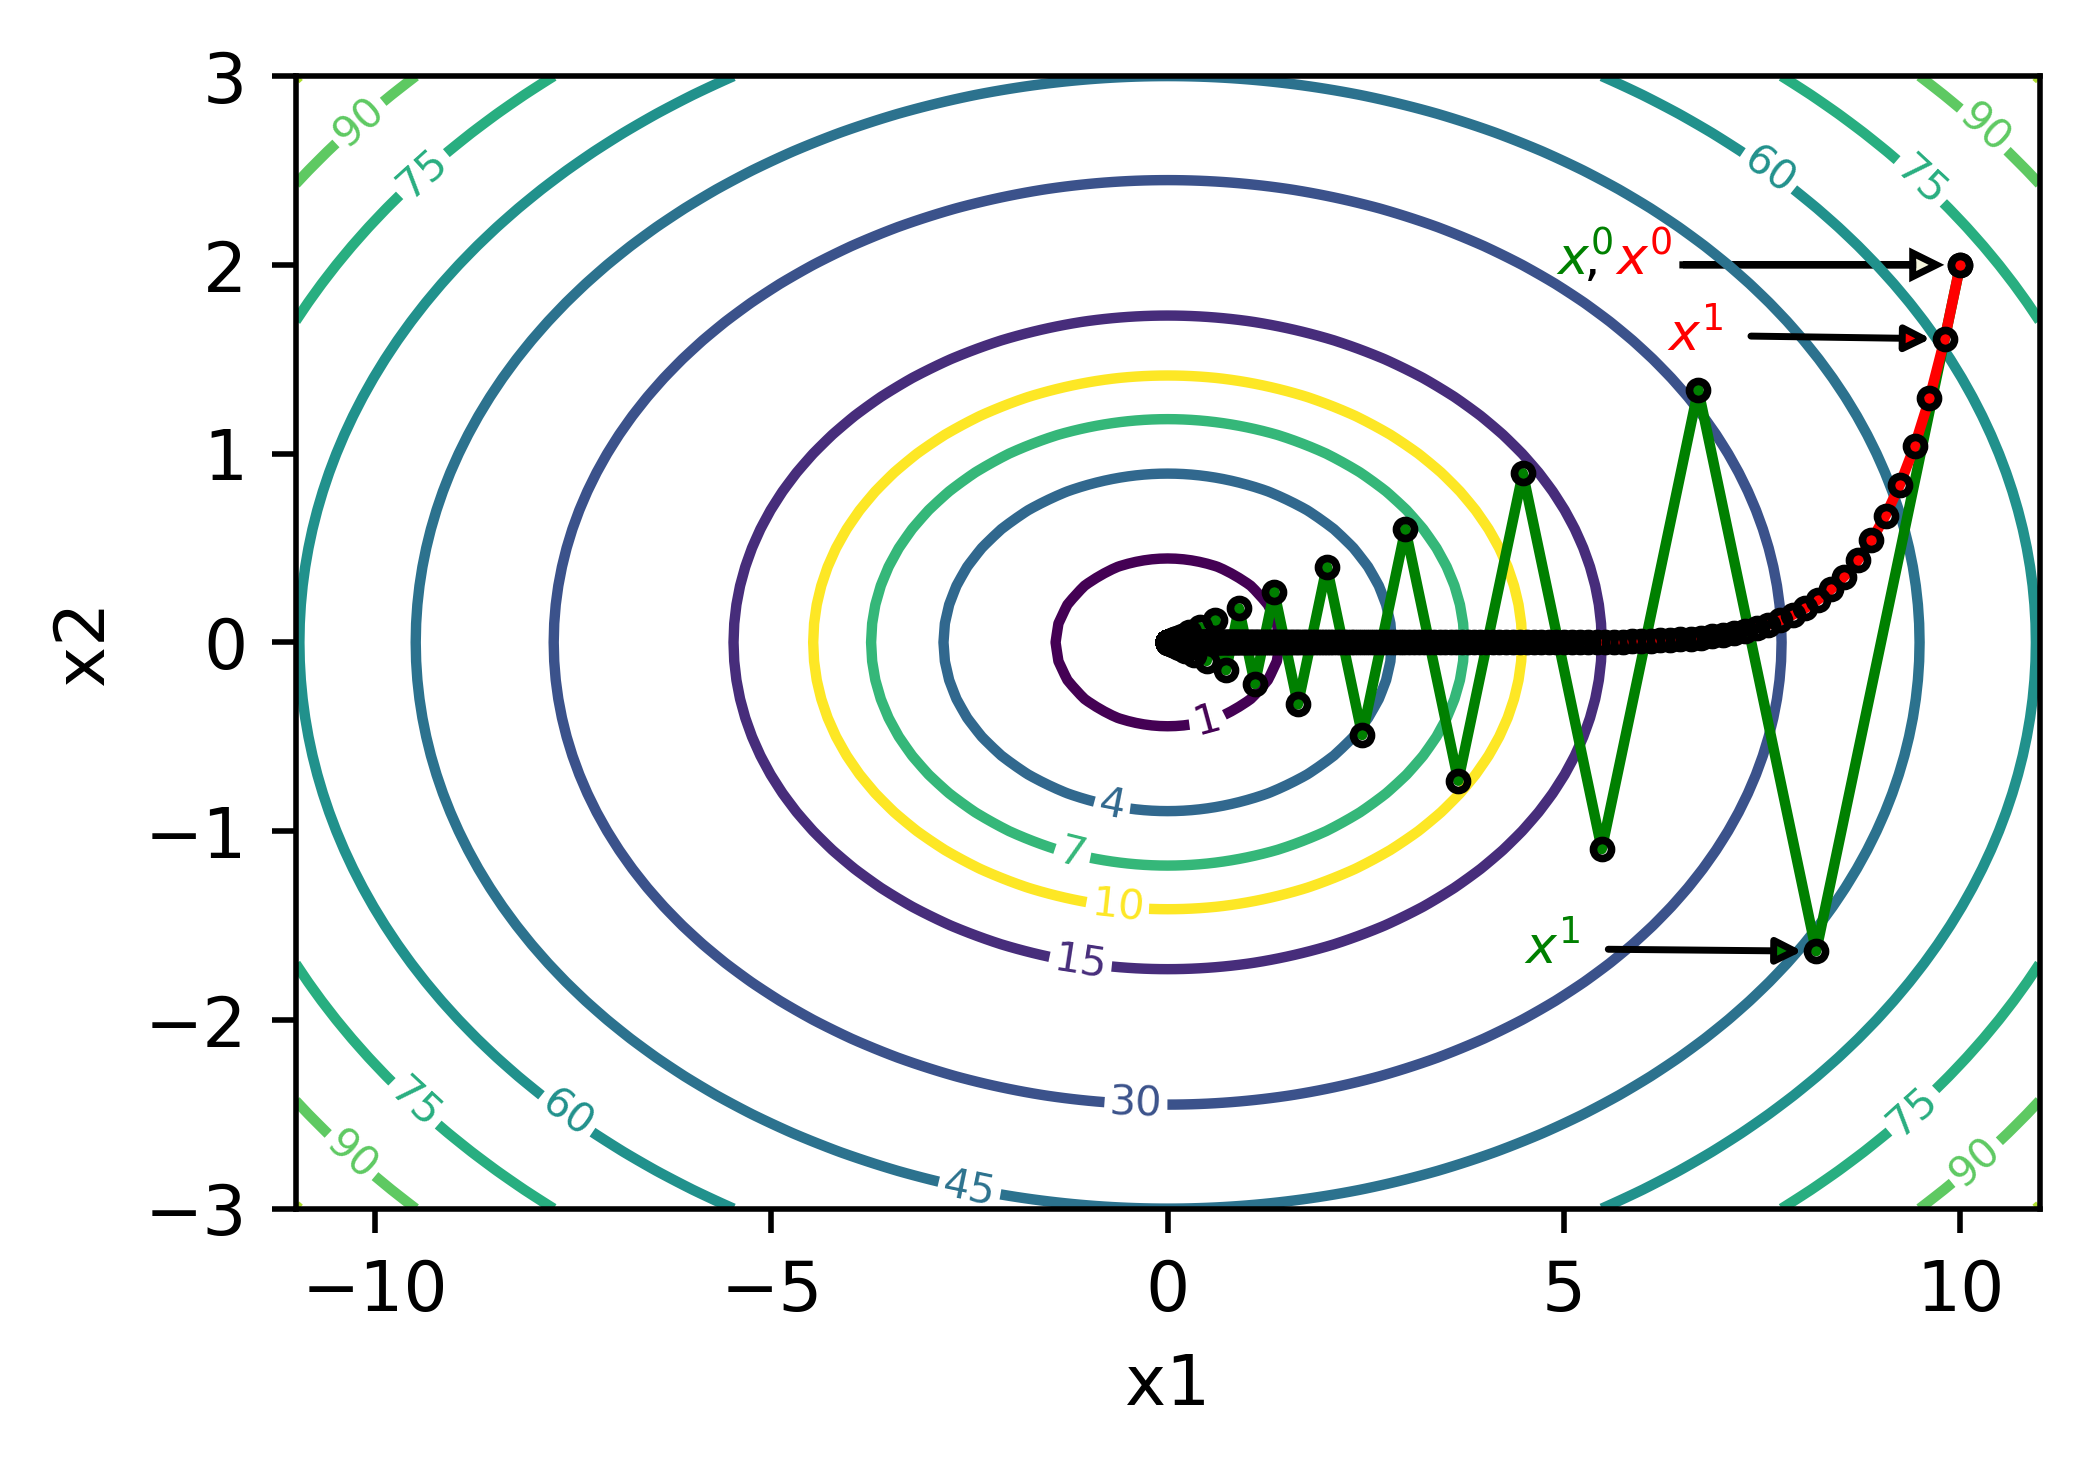

In [11]:
width_of_panel = 4.5 
height_of_panel = 3
d = 500
plt.figure(figsize=(width_of_panel, height_of_panel), dpi=d)

x1 = np.arange(-11, 11.1, 0.1)
x2 = np.arange(-3., 3.1, 0.1)
x1, x2 = np.meshgrid(x1, x2)
z = (x1**2 +10*(x2**2)) / 2

levels = [1, 4, 7, 10]
cp1 = plt.contour(x1, x2, z, levels=levels)
cp2 = plt.contour(x1, x2, z)

plt.clabel(cp1, inline=1, fontsize=6)
plt.clabel(cp2, inline=1, fontsize=6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(x_one(min_gd_iii_fixed(fun, [10,2], grad, 1/5.5)), x_two(min_gd_iii_fixed(fun, [10,2], grad, 1/5.5)), color='green')
plt.plot(x_one(min_gd_iii_fixed(fun, [10,2], grad, 1/5.5))[:], x_two(min_gd_iii_fixed(fun, [10,2], grad, 1/5.5))[:], "or", markerfacecolor="None", markeredgecolor='black', markeredgewidth=1.1, markersize=2.6)
plt.plot(x_one(min_gd_iii_fixed(fun, [10,2], grad, 1/51)), x_two(min_gd_iii_fixed(fun, [10,2], grad, 1/51)), color='red')
plt.plot(x_one(min_gd_iii_fixed(fun, [10,2], grad, 1/51))[:], x_two(min_gd_iii_fixed(fun, [10,2], grad, 1/51))[:], "or", markerfacecolor="None", markeredgecolor='black', markeredgewidth=1.1, markersize=2.6)

plt.annotate("$x^0$", fontsize = 7.5, xy=(10,2), xytext=(4.9, 1.95), arrowprops=None, color='green')
plt.annotate(",", fontsize = 7.5, xy=(10,2), xytext=(5.25, 1.95))
plt.annotate("$x^0$", fontsize = 7.5, xy=(10,2), xytext=(5.65, 1.95), color='red')
plt.arrow(6.5, 2, 2.9, 0, head_width=0.125, head_length=0.3, fc='beige')
plt.annotate("$x^1$", fontsize = 7.5, xy=(8.181818181818182,-1.6363636363636367), xytext=(4.5,-1.7), arrowprops=dict(arrowstyle = '-|>', connectionstyle = 'Arc3', facecolor='g'), color='green')
plt.annotate("$x^1$", fontsize = 7.5, xy=(9.803921568627452,1.607843137254902), xytext=(6.3,1.55), arrowprops=dict(arrowstyle = '-|>', connectionstyle = 'Arc3',facecolor='r'), color='red')
plt.show() 

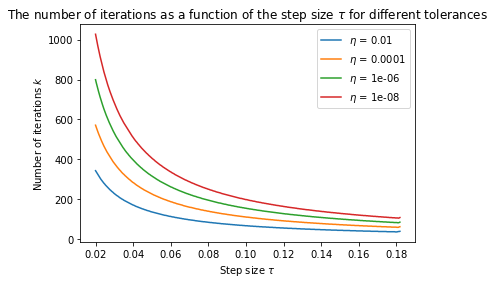

In [12]:
# define a function to generate the plot for a given tolerance value
def plot_tol(tol):
    # create an array of t values
    t_values = np.linspace(2/11, 1/50, num=400)

    # create an empty array to store the output of the function for each t value
    output_values = np.zeros_like(t_values)

    # evaluate the function for each t value and store the output
    for i, t in enumerate(t_values):
        output_values[i] = min_gd_iv_fixed(fun, [10,2], grad, t, tol=tol)

    # plot the output as a function of t
    plt.plot(t_values, output_values, label=fr"$\eta$ = {tol}")

# create a list of tolerance values to generate plots for
tol_values = [1e-2, 1e-4, 1e-6, 1e-8]

# create the plot with multiple subplots
fig, ax = plt.subplots()

# generate a plot for each tolerance value
for tol in tol_values:
    plot_tol(tol)

# set the labels and title for the plot
ax.set_xlabel(r'Step size $\tau$')
ax.set_ylabel(r'Number of iterations $k$')
ax.set_title(r'The number of iterations as a function of the step size $\tau$ for different tolerances')

# add a legend to the plot
plt.legend()

# show the plot
plt.show()